In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm as tqdm
from torch.utils.data import Dataset
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import umap.umap_ as umap
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Jojo\miniconda3\envs\amp_ss25\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Path to the .npz file
DATASET_PATH = "../../MLPC2025_classification"

ANNOTATIONS_PATH = DATASET_PATH + "/annotations.csv"
#ANNOTATIONS_TEXT_EMBEDDINGS_PATH = DATASET_PATH + "/annotations_text_embeddings.npz"

METADATA_PATH = DATASET_PATH + "/metadata.csv"
#METADATA_TITLE_EMBEDDINGS_PATH = DATASET_PATH + "/metadata_title_embeddings.npz"
#METADATA_KEYWORDS_EMBEDDINGS_PATH = DATASET_PATH + "/metadata_keywords_embeddings.npz"

AUDIO_PATHS = DATASET_PATH + "/audio"
AUDIO_FEATURES_PATHS = DATASET_PATH + "/audio_features"

LABELS_PATH = DATASET_PATH + "/labels"

In [3]:
annotations = pd.read_csv(ANNOTATIONS_PATH)
annotations.head()

,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
0,161976549,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing loudly and repeatedly nearby.,0.000000,10.503064,345.033,Raw loud alarm sound repeatedly ringing nearby,['Alarm']
1,161976549,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing repeatedly nearby.,12.514616,23.048000,345.033,Clean alarm sound repeatedly ringing nearby,['Alarm']
2,161976550,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,0.000000,13.414880,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
3,161976550,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,15.134252,28.492000,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
4,161976551,119173.mp3,8105077500224920444298835829881210427871190692...,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']"


In [4]:
# Remove unnecessary columns for this task
annotations = annotations.drop(columns=['task_id'])
annotations['original_index'] = annotations.index
annotations.head()

,filename,annotator,text,onset,offset,time,original_caption,categories,original_index
0,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing loudly and repeatedly nearby.,0.000000,10.503064,345.033,Raw loud alarm sound repeatedly ringing nearby,['Alarm'],0
1,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing repeatedly nearby.,12.514616,23.048000,345.033,Clean alarm sound repeatedly ringing nearby,['Alarm'],1
2,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,0.000000,13.414880,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']",2
3,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,15.134252,28.492000,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']",3
4,119173.mp3,8105077500224920444298835829881210427871190692...,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']",4


In [5]:
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,filename,keywords,freesound_id,sound_link,manufacturer,license,title,description,num_downloads,geotag,start_time_s,end_time_s
0,321771.mp3,"Interior, AMB, Italy, Distant, Speech, Reverb",321771,https://freesound.org/people/Skjor1/sounds/321...,Skjor1,http://creativecommons.org/publicdomain/zero/1.0/,Interior Ambience + Distant Reverberant Speech...,Interior Ambience + Distant Reverberant Speech...,120,NaN,5.200,27.179
1,451371.mp3,"kids, throaty, crowd, India, distant, traffic,...",451371,https://freesound.org/people/kyles/sounds/451371/,kyles,http://creativecommons.org/publicdomain/zero/1.0/,election rally crowd and speech with distant t...,election rally crowd and speech with distant t...,122,NaN,120.800,144.984
2,199414.mp3,"broadcast, speech, radio",199414,https://freesound.org/people/martinimeniscus/s...,martinimeniscus,http://creativecommons.org/publicdomain/zero/1.0/,"Old Radio Speech Background, higher FF125.aif",Background noise for an old radio broadcast sp...,391,NaN,102.003,130.921
3,410952.mp3,"loop2017, atmos, dolby, speech, ableton",410952,https://freesound.org/people/lietoofine/sounds...,lietoofine,https://creativecommons.org/licenses/by/4.0/,dolby atmos speech.wav,dolby atmos speech @Loop2017,193,52.479543 13.500279,31.330,54.021
4,203908.mp3,"dr-40, project, speech, student, italian, reci...",203908,https://freesound.org/people/s9ames/sounds/203...,s9ames,http://creativecommons.org/licenses/by/3.0/,bologna speech Italian2,recorded with a tascam dr-40 in a sound studio...,526,NaN,29.200,45.689


In [6]:
# Remove unnecessary columns for this task
metadata = metadata.drop(columns=['freesound_id', 'sound_link', 'manufacturer', 'license', 'num_downloads', 'geotag', 'start_time_s', 'end_time_s'])
metadata.head()

,filename,keywords,title,description
0,321771.mp3,"Interior, AMB, Italy, Distant, Speech, Reverb",Interior Ambience + Distant Reverberant Speech...,Interior Ambience + Distant Reverberant Speech...
1,451371.mp3,"kids, throaty, crowd, India, distant, traffic,...",election rally crowd and speech with distant t...,election rally crowd and speech with distant t...
2,199414.mp3,"broadcast, speech, radio","Old Radio Speech Background, higher FF125.aif",Background noise for an old radio broadcast sp...
3,410952.mp3,"loop2017, atmos, dolby, speech, ableton",dolby atmos speech.wav,dolby atmos speech @Loop2017
4,203908.mp3,"dr-40, project, speech, student, italian, reci...",bologna speech Italian2,recorded with a tascam dr-40 in a sound studio...


Idea for splitting the data:

Use some fixed percentages for training, validation, and test sets (e.g., 70% training, 15% validation, 15% test).
Then, for each label, ensure that the same percentage of files is allocated to each set. This way, you maintain the label distribution across all sets.

Additionally, some resampling (e.g. SMOTE), undersampling (e.g. RUS, TOMEK) or class weighting techniques can be applied to maintain balance during training.

In [7]:
class AudioClassificationDataset(Dataset):

    def __init__(self, data_dir, audio_features_subset, return_snippets, context_length, testing):
        """
        data_dir: Path to the dataset directory
        audio_features_subset: List of audio features to be used
        return_snippets: If False, return whole files, if True, return snippets of size context_length
        context_length: Length of the snippets to be returned (ideally uneven number)
        testing: If True, use a small subset of the audio files for testing
        """

        self.return_snippets = return_snippets
        self.context_length = context_length

        audio_path = os.path.join(data_dir, 'audio')

        # For testing purposes, use a smaller subset of the audio files (just copy some audio files from the audio directory
        # to a new directory at the same level)
        #audio_path = os.path.join(data_dir, 'audio_subset_test')

        self.audio_file_basenames = [os.path.splitext(os.path.basename(name))[0] for name in os.listdir(audio_path) if name.endswith('.mp3')]
        self.audio_file_features = []
        self.audio_file_labels = []

        for audio_file_idx, audio_file_basename in enumerate(tqdm(self.audio_file_basenames)):

            # Remove unwanted features and store remaining features
            audio_features_dict = dict(np.load(os.path.join(data_dir, 'audio_features', audio_file_basename + '.npz')))
            audio_features = [audio_features_dict[wanted_feature] for wanted_feature in audio_features_subset]

            n_frames = audio_features[0].shape[0]

            # store whole file at once
            if not self.return_snippets:
                self.audio_file_features.append(audio_features)
            # store single snippets
            else:
                # Pad so that edge-frames have context
                padding = ((context_length//2, context_length//2), (0, 0))
                audio_features = [np.pad(array=feature, pad_width=padding, mode='constant', constant_values=0) for feature in audio_features]

                for frame_idx in range(n_frames):
                    frame_features = [audio_feature[frame_idx:frame_idx + context_length] for audio_feature in audio_features]
                    self.audio_file_features.append((audio_file_idx, frame_idx, frame_features))

            # Store labels
            audio_labels_dict = dict(np.load(os.path.join(data_dir, 'labels', audio_file_basename + '_labels.npz')))

            n_labels = len(audio_labels_dict.keys())
            file_labels = np.zeros((n_frames, n_labels))
            for i, (label_name, label_values) in enumerate(audio_labels_dict.items()):

                # If there are multiple label sets -> multiple annotators
                if label_values.shape[1] != 1:
                    # Like discussed in the exercise class, we choose one at random
                    label_values = label_values[:, np.random.randint(0, label_values.shape[1]), np.newaxis]

                file_labels[:, i] = label_values[:, 0]

            # store labels for whole file at once
            if not self.return_snippets:
                self.audio_file_labels.append(file_labels)
            # store labels for single snippets
            else:
                for frame_idx, frame_labels in enumerate(file_labels):
                    self.audio_file_labels.append((audio_file_idx, frame_idx, frame_labels))

            if testing and audio_file_idx == 1000:
                break

    def __len__(self):
            return len(self.audio_file_labels)

    def __getitem__(self, idx):
        if not self.return_snippets:
            return self.audio_file_basenames[idx], self.audio_file_features[idx], self.audio_file_labels[idx]
        else:
            file_idx, frame_idx, frame_features = self.audio_file_features[idx]
            file_idx, frame_idx, frame_labels = self.audio_file_labels[idx]
            return file_idx, self.audio_file_basenames[file_idx], frame_idx, frame_features, frame_labels

In [8]:
data = AudioClassificationDataset(
    data_dir = DATASET_PATH,
    audio_features_subset = ['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate'],
    return_snippets = True,
    context_length = 1,
    testing = False
)
print(f"Dataset size: {len(data)}")

100%|██████████| 8230/8230 [03:33<00:00, 38.59it/s] 

Dataset size: 1538577


In [11]:
print("This is what the data looks like:")
for i, example in enumerate(data):
    if not data.return_snippets:
        audio_name, features, labels = example
        print(f"Name: {audio_name}, Feature dim: {[f.shape for f in features]}, Label dim: {labels.shape}")
    elif data.return_snippets:
        file_idx, audio_name, frame_idx, features, labels = example
        print(f"Name: {audio_name}, Frame: {frame_idx}, Feature dim: {[f.shape for f in features]}, Label dim: {labels.shape}")

    if i > 1000:
        break

This is what the data looks like:
Name: 100300, Frame: 0, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 32), (1, 32), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 7), (1, 1)], Label dim: (58,)
Name: 100300, Frame: 1, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 32), (1, 32), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 7), (1, 1)], Label dim: (58,)
Name: 100300, Frame: 2, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 32), (1, 32), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 7), (1, 1)], Label dim: (58,)
Name: 100300, Frame: 3, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 32), (1, 32), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 7), (1, 1)], Label dim: (58,)
Name: 100300, Frame: 4, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 32), (1, 32), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 7), (1, 1)], Label dim: (58,)
Name: 100300, Frame: 5, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 32), (1, 32), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 

In [12]:
overlapping_regions_count = {}
for example in tqdm(data):
    file_idx, audio_name, frame_idx, features, labels = example
    
    for l, label_value in enumerate(labels):
        label_value = int(label_value)
        if label_value != 0 and label_value != 1:
            try:
                overlapping_regions_count[label_value] += 1
            except KeyError:
                overlapping_regions_count[label_value] = 1
#
print(f"Number frames with same-label overlap: {np.sum(list(overlapping_regions_count.values()))}")
print(f"Percentage of frames with overlap: {np.sum(list(overlapping_regions_count.values()))/len(data):.4f}%")
for n_overlaps, count in overlapping_regions_count.items():
    print(f"Order of overlaps: {n_overlaps}, Count: {count}, Percentage: {count/len(data):.4f}%")

100%|██████████| 1538577/1538577 [00:15<00:00, 96922.14it/s]

Number frames with same-label overlap: 88300
Percentage of frames with overlap: 0.0574%
Order of overlaps: 2, Count: 80229, Percentage: 0.0521%
Order of overlaps: 4, Count: 1280, Percentage: 0.0008%
Order of overlaps: 3, Count: 6464, Percentage: 0.0042%
Order of overlaps: 5, Count: 266, Percentage: 0.0002%
Order of overlaps: 6, Count: 61, Percentage: 0.0000%


In [13]:
all_labels = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

all_features = ['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']

context_length = data.context_length

_, _, _, example_features, labels = data[0]

all_feature_dims = [feature.shape[1] for feature in example_features]
all_feature_dims = np.array(all_feature_dims) * context_length

feature_dim_borders = np.cumsum(all_feature_dims)
feature_dim_borders = np.insert(feature_dim_borders, 0, 0)

label_subset = np.random.choice(all_labels, size=5, replace=False)
label_subset = ['Insect Buzz', 'Drip', 'Clapping', 'Piano', 'Train'] # Manually overwrite for testing
label_subset_indices = [i for i, label in enumerate(all_labels) if label in label_subset]

data_indices = np.arange(len(data))
np.random.shuffle(data_indices)

In [14]:
# method 1 for getting examples: Just specify a number of examples of use and randomly sample them
"""
total_examples = 10**4

X = np.zeros((total_examples, feature_dim_borders[-1]))
Ys = np.zeros((total_examples, len(label_subset_indices)))

for i, idx in enumerate(data_indices[:total_examples]):
    
    _, _, _, features, labels = data[idx]
    
    labels = np.where(labels >= 0.5, 1, 0)
    labels = labels[label_subset_indices]
    
    Ys[i] = labels.flatten()
    
    for f, feature in enumerate(features):
        feature = feature.flatten()
        if np.std(feature) != 0:
            feature = (feature - np.mean(feature)) / np.std(feature)
        else:
            feature = (feature - np.mean(feature))
            
        X[i, feature_dim_borders[f]:feature_dim_borders[f+1]] = feature
    
X = np.array(X)
Ys = np.array(Ys)
"""

'\ntotal_examples = 10**4\n\nX = np.zeros((total_examples, feature_dim_borders[-1]))\nYs = np.zeros((total_examples, len(label_subset_indices)))\n\nfor i, idx in enumerate(data_indices[:total_examples]):\n    \n    _, _, _, features, labels = data[idx]\n    \n    labels = np.where(labels >= 0.5, 1, 0)\n    labels = labels[label_subset_indices]\n    \n    Ys[i] = labels.flatten()\n    \n    for f, feature in enumerate(features):\n        feature = feature.flatten()\n        if np.std(feature) != 0:\n            feature = (feature - np.mean(feature)) / np.std(feature)\n        else:\n            feature = (feature - np.mean(feature))\n            \n        X[i, feature_dim_borders[f]:feature_dim_borders[f+1]] = feature\n    \nX = np.array(X)\nYs = np.array(Ys)\n'

In [15]:
# method 2 for getting examples: keep sampling until a minimum number of examples per label has been reached 
min_examples_per_label = 2000 

X = []
Ys = []

missing_labels = np.ones((len(label_subset_indices))) * min_examples_per_label
for i, idx in enumerate(data_indices):
    
    if np.all(missing_labels == 0): 
        break
    
    _, _, _, features, labels = data[idx]
    
    labels = np.where(labels >= 0.5, 1, 0)
    labels = labels[label_subset_indices]
    
    new_missing_labels = missing_labels - labels
    if np.any(new_missing_labels < 0) or np.dot(missing_labels, labels) == 0:
        continue
    else:
        missing_labels = new_missing_labels
        X.append([])
        Ys.append([])
        
        Ys[-1] = labels.flatten()
        
        for f, feature in enumerate(features):
            feature = feature.flatten()
            
            if np.std(feature) != 0:
                feature = (feature - np.mean(feature)) / np.std(feature)
            else:
                feature = (feature - np.mean(feature))
            X[-1].extend(feature)
            
    if i%10000 == 0:
        print(f"Amount of still missing labels: {missing_labels}")
        
X = np.array(X)
Ys = np.array(Ys)

In [16]:
# Get feature importances based of Mutual Information
feature_importances_per_label_mi = np.zeros((len(label_subset), len(all_features)))

# Compute MI for each label
for i in tqdm(range(len(label_subset))):
    mi_scores = mutual_info_classif(X, Ys[:, i], discrete_features=False , n_jobs=32)
    for j in range(len(all_features)):
        feature_mi = mi_scores[feature_dim_borders[j]:feature_dim_borders[j+1]]
        feature_mi = np.mean(feature_mi)
        feature_importances_per_label_mi[i, j] = feature_mi    
    feature_importances_per_label_mi[i] = feature_importances_per_label_mi[i] / np.sum(feature_importances_per_label_mi[i])

100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


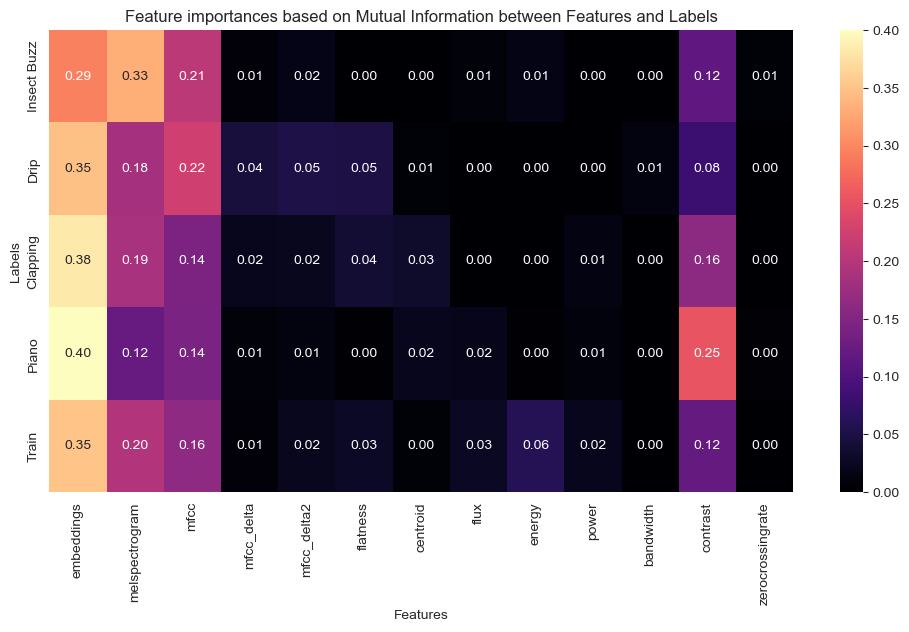

In [17]:
# Plot results
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importances_per_label_mi, cmap='magma', xticklabels=[feature for feature in all_features], yticklabels=[label for label in label_subset], annot=True, fmt=".2f")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Feature importances based on Mutual Information between Features and Labels")
plt.show()

In [18]:
# Get feature importances based of classifier
feature_importances_per_label_ml = []

for y in tqdm(range(len(label_subset_indices))):
    Y = Ys[:, y]
    
    # Using Logistic Regression
    # base_clf = LogisticRegression(tol=10**-4, max_iter=10**50)
    
    # Using Random Forest
    clf = RandomForestClassifier(verbose=0, n_jobs=32)#, min_samples_split=500, min_samples_leaf=250)
    
    clf.fit(X, Y)
    
    # Using Logistic Regression
    #importances = base_clf.coef_
    
    # Using Random Forest
    importances = clf.feature_importances_
    feature_importances = []
    
    for i in range(len(feature_dim_borders)-1):
        feature_start = feature_dim_borders[i]
        feature_end = feature_dim_borders[i+1]
        feature_importances.append(np.sum(importances[feature_start:feature_end]))
           
    feature_importances_per_label_ml.append(np.array(feature_importances))
    
feature_importances_per_label_ml = np.array(feature_importances_per_label_ml)

100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


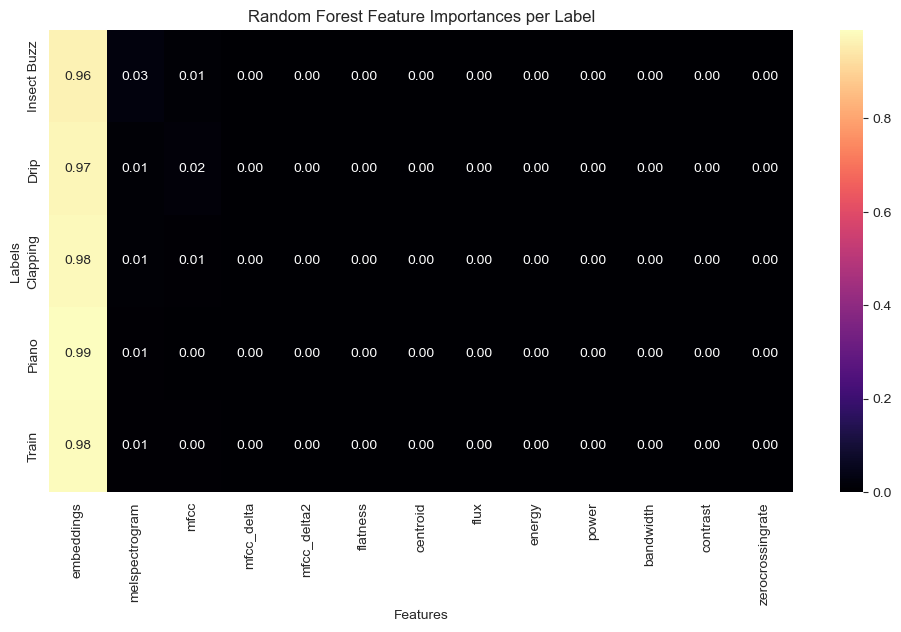

In [19]:
# Plot results
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importances_per_label_ml, cmap='magma', xticklabels=[feature for feature in all_features], yticklabels=[label for label in label_subset], annot=True, fmt=".2f")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Random Forest Feature Importances per Label")
plt.show()

In [20]:
# Clustering according to selected features
selected_features = ['embeddings', 'melspectrogram', 'mfcc', 'contrast']
selected_features_indices = [i for i, feature in enumerate(all_features) if feature in selected_features]

selected_feature_dims = [feature_dim_borders[i+1]-feature_dim_borders[i] for i in selected_features_indices]
selected_feature_dim_borders = [(feature_dim_borders[i],feature_dim_borders[i+1]) for i in selected_features_indices]

In [21]:
# Prepare data for clustering
selected_X = np.zeros((X.shape[0], np.sum(selected_feature_dims)))
selected_Ys = Ys

for i in range(X.shape[0]):
    features = []
    for (start, end) in selected_feature_dim_borders:
        features.extend(X[i, start:end])
    selected_X[i, :] = np.array(features)

for i in range(Ys.shape[0]):
    n_labels = np.sum(selected_Ys[i])
    if n_labels != 1:
        possible_labels = np.where(selected_Ys[i] == 1)[0]
        labels_to_delete = np.random.choice(possible_labels, size=n_labels-1, replace=False)
        for label in labels_to_delete:
            selected_Ys[i, label] = 0

class_indices = np.argmax(selected_Ys, axis=1)

In [23]:
# Dimensionality Reduction

reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
# reducer = umap.UMAP(n_jobs=20)

selected_X_reduced = reducer.fit_transform(selected_X)

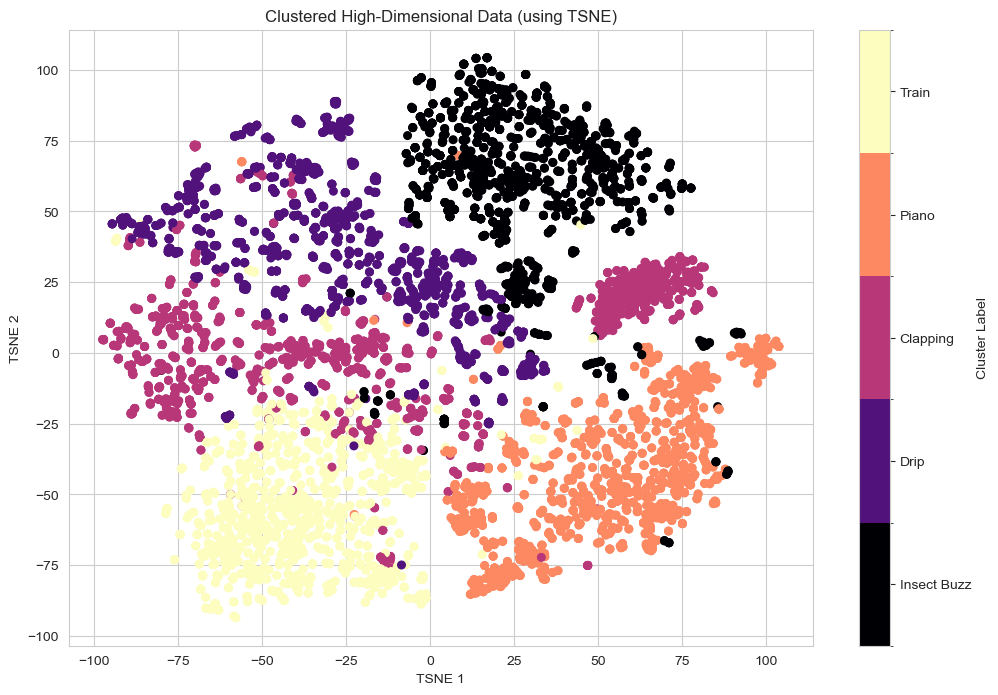

In [29]:
# Plot results
from matplotlib.colors import BoundaryNorm

cmap = plt.get_cmap('magma', len(label_subset))
bounds = np.arange(len(label_subset) + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(selected_X_reduced[:, 0], selected_X_reduced[:, 1], c=class_indices, cmap=cmap, norm=norm, s=30)

cbar = plt.colorbar(scatter, ticks=np.arange(len(label_subset)))
cbar.set_label("Cluster Label")
cbar.set_ticklabels([label_subset[i] for i in range(len(label_subset))])  # optional

plt.title("Clustered High-Dimensional Data (using TSNE)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.grid(True)
plt.show()